# Loan Status Prediction with Bidirectional LSTM (biLSTM)


## Dataset Description

**Project Description**

This project aims to predict loan status using data science and machine learning techniques. The dataset used in this project contains information about loan applicants and various factors influencing the loan status. By utilizing the features from this dataset, we will build a predictive model to classify whether an applicant will default or not.

**Dataset Features**

The dataset consists of 32,581 entries with 12 feature columns as follows:

1. **person_age**: Age of the applicant.
2. **person_income**: Annual income of the applicant.
3. **person_home_ownership**: Home ownership status of the applicant (e.g., rent, own, etc.).
4. **person_emp_length**: Employment length of the applicant (in years).
5. **loan_intent**: Purpose of the loan (e.g., education, business, etc.).
6. **loan_grade**: Loan grade representing credit risk.
7. **loan_amnt**: Loan amount requested.
8. **loan_int_rate**: Interest rate of the loan.
9. **loan_status**: Loan status (0 for non-default, 1 for default).
10. **loan_percent_income**: Percentage of income used for the loan.
11. **cb_person_default_on_file**: Historical default status of the applicant.
12. **cb_person_cred_hist_length**: Length of the applicant's credit history.

**Objective**

The primary objective of this project is to develop a machine learning model that accurately predicts the likelihood of a loan default based on the provided features. This model will help financial institutions make more informed decisions and mitigate financial risks associated with lending.

By analyzing various factors such as age, income, home ownership, employment length, loan intent, loan grade, loan amount, interest rate, and credit history, we aim to create a robust predictive model. This model will not only be accurate but also interpretable, providing valuable insights into the key drivers of loan defaults.

Through this project, we seek to enhance our understanding of the factors contributing to loan defaults and demonstrate the practical application of data science techniques in the financial industry.

## Libraries


In [1]:
# Basic Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preparation and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTENC

# Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading


In [2]:
!kaggle datasets download -d laotse/credit-risk-dataset

Dataset URL: https://www.kaggle.com/datasets/laotse/credit-risk-dataset
License(s): CC0-1.0
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 20.6MB/s]


In [3]:
!unzip /content/credit-risk-dataset.zip

Archive:  /content/credit-risk-dataset.zip
  inflating: credit_risk_dataset.csv  


In [4]:
# import CSV into dataframe
df = pd.read_csv('/content/credit_risk_dataset.csv')

In [5]:
# dataframe
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [6]:
print(f'DataFrame Dimension : {df.shape}')

DataFrame Dimension : (32581, 12)


## Data Cleaning

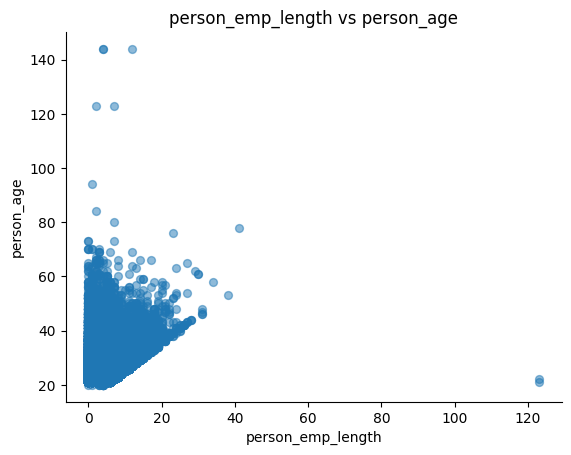

In [7]:
# person_emp_length vs person_age

df.plot(kind='scatter', x='person_emp_length', y='person_age', s=32, alpha=.5 )
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('person_emp_length vs person_age')
plt.show()

There are several **anomalies** in the data, namely points that represent individuals with a length of service of more than 100 years and an age of more than 80 years. This is considered unusual or wrong because it is impossible for someone who has a long service life or is more than 100 years old to be there. credit loan data. This is likely caused by a data entry error. Therefore, we will delete rows where there is age or length of work more than 100.

In [8]:
# @title Removing employment length and age anomaly
df_clean = df[(df['person_emp_length'] <= 60) & (df['person_age'] <= 80)]

In [9]:
# Checking Datframe info
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31677 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31677 non-null  int64  
 1   person_income               31677 non-null  int64  
 2   person_home_ownership       31677 non-null  object 
 3   person_emp_length           31677 non-null  float64
 4   loan_intent                 31677 non-null  object 
 5   loan_grade                  31677 non-null  object 
 6   loan_amnt                   31677 non-null  int64  
 7   loan_int_rate               28631 non-null  float64
 8   loan_status                 31677 non-null  int64  
 9   loan_percent_income         31677 non-null  float64
 10  cb_person_default_on_file   31677 non-null  object 
 11  cb_person_cred_hist_length  31677 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.1+ MB


In [10]:
# Checking for null data
df_clean.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3046
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [11]:
# @title Removing NaN
df_clean = df_clean.dropna(subset=['loan_int_rate'])

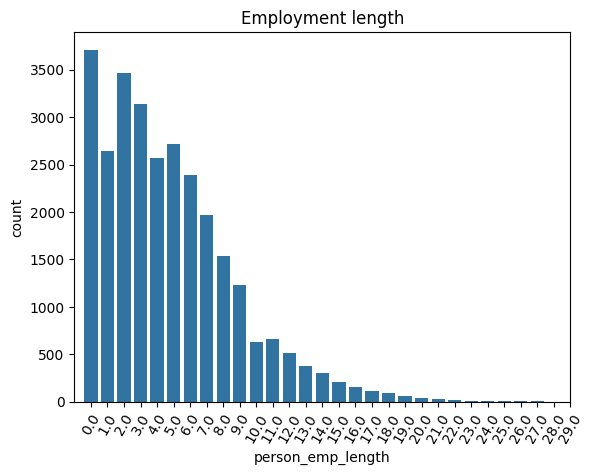

In [12]:
sns.countplot(x='person_emp_length',data=df_clean)
plt.title("Employment length")
plt.xticks(rotation=60)
plt.xlim(-1,29)
plt.show()

In [13]:
# @title Fill in employment length outlier data with median
df_clean['person_emp_length'].fillna(df_clean['person_emp_length'].median() , inplace = True)

It can be seen that the dataframe is clean and can be used for analysis and building ML models

In [14]:
df_clean

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28631 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28631 non-null  int64  
 1   person_income               28631 non-null  int64  
 2   person_home_ownership       28631 non-null  object 
 3   person_emp_length           28631 non-null  float64
 4   loan_intent                 28631 non-null  object 
 5   loan_grade                  28631 non-null  object 
 6   loan_amnt                   28631 non-null  int64  
 7   loan_int_rate               28631 non-null  float64
 8   loan_status                 28631 non-null  int64  
 9   loan_percent_income         28631 non-null  float64
 10  cb_person_default_on_file   28631 non-null  object 
 11  cb_person_cred_hist_length  28631 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


In [16]:
df_clean.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## EDA

In [17]:
data_for_graphic = df_clean.copy()
data_for_graphic['loan_grade'] = data_for_graphic['loan_grade'].astype('category')
data_for_graphic.sort_values(by='loan_grade', inplace=True)

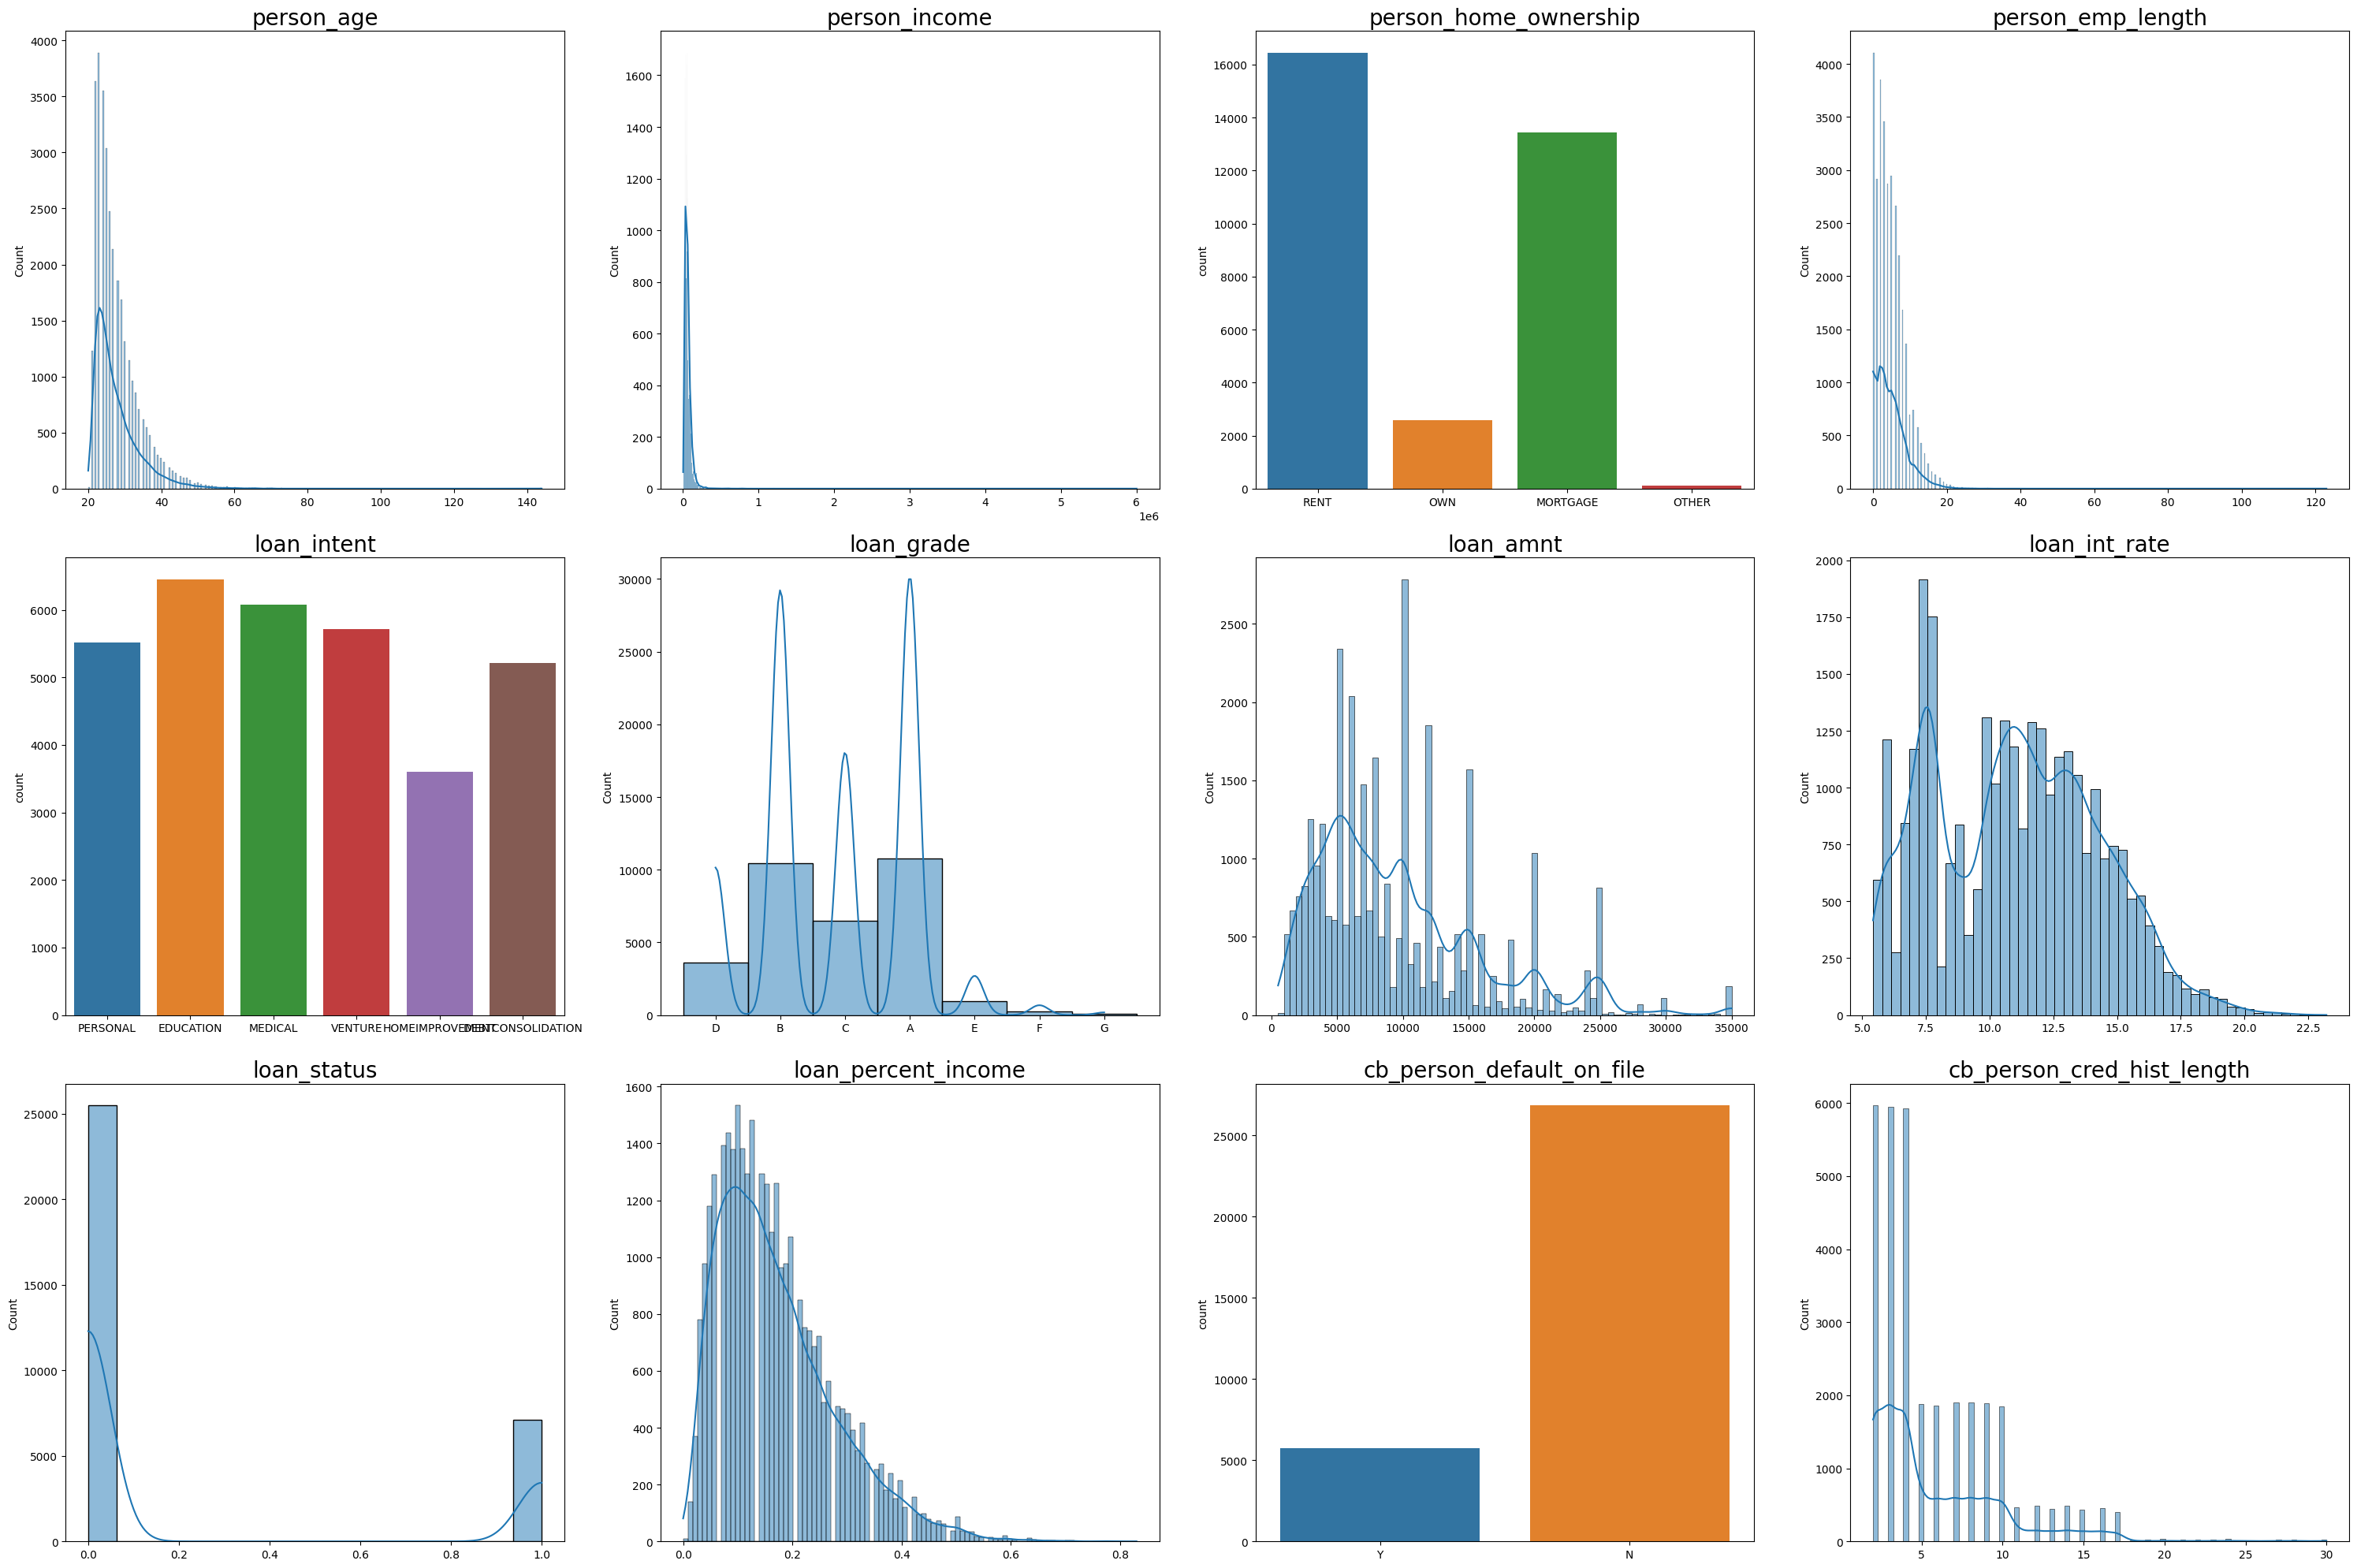

In [18]:
# @title Distribution each column

# Plotting the data distribution for each column
fig, ax = plt.subplots(3, 4)
fig.set_size_inches(30, 20)

features = data_for_graphic.columns
numerical_features = data_for_graphic.select_dtypes(exclude='object')

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    if feature in numerical_features:
        hist = sns.histplot(data=df, x=feature, ax=ax[row, col], kde=True)
    else:
        hist = sns.countplot(data=df, x=feature, ax=ax[row, col], hue=feature)
    hist.set_title(feature, fontsize=20)
    hist.set_xlabel('')


plt.tight_layout()
plt.show()

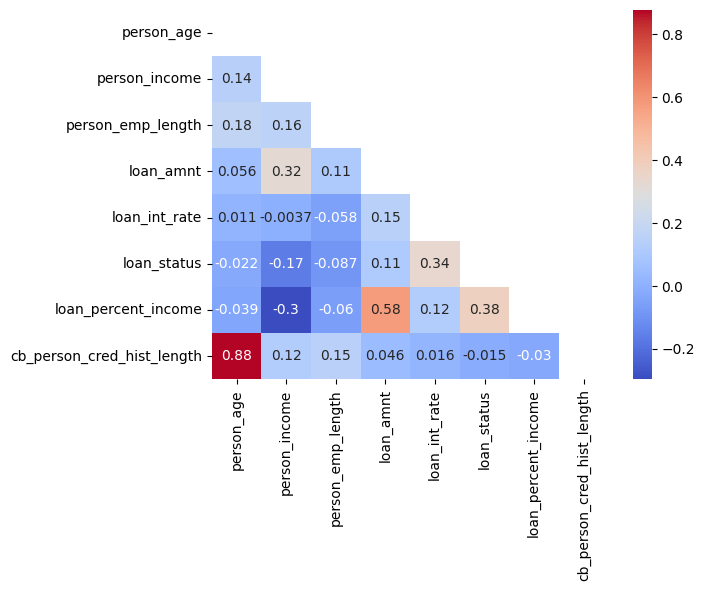

In [19]:
# @title Correlation
df_num = data_for_graphic.select_dtypes(exclude=['object','category'])
sns.heatmap(df_num.corr(), cmap='coolwarm',
            annot=True, mask=np.triu(np.ones_like(df_num.corr(), dtype=bool)))
plt.show()

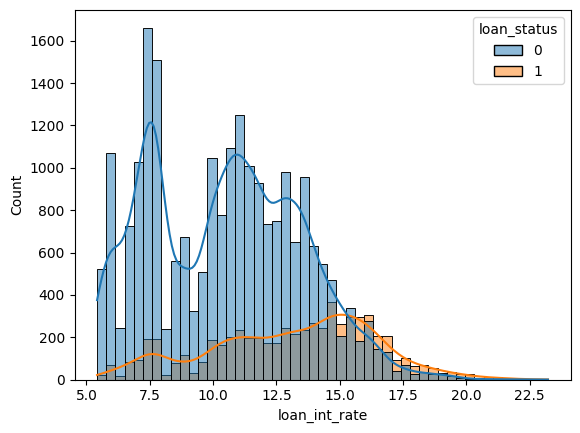

In [20]:
sns.histplot(data= data_for_graphic, x='loan_int_rate', kde=True, hue = 'loan_status')
plt.show()

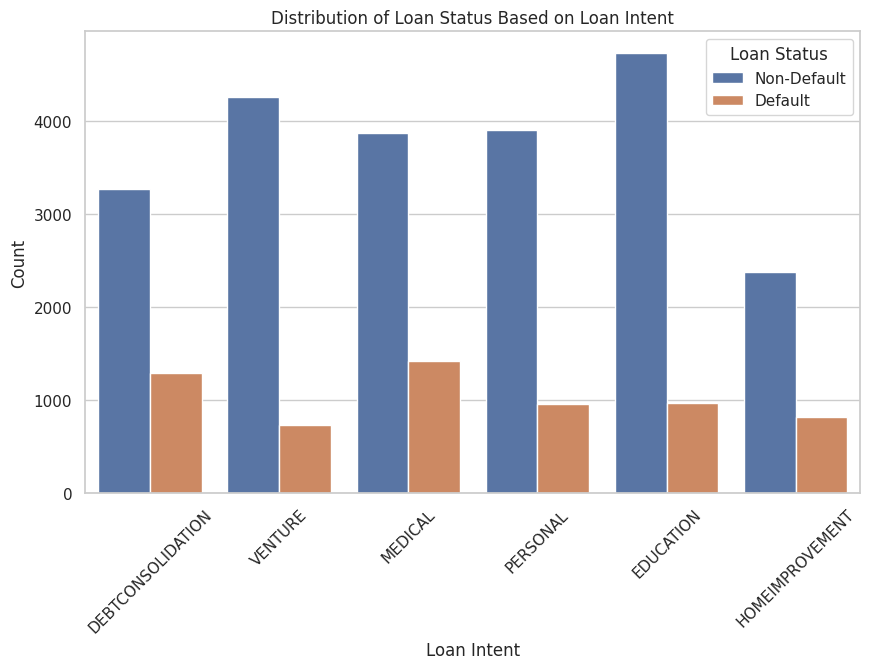

In [21]:
# Setting up the aesthetic style of the plots
sns.set(style="whitegrid")

# Distribution of Loan Status Based on Loan Intent
plt.figure(figsize=(10, 6))
sns.countplot(data=data_for_graphic, x='loan_intent', hue='loan_status')
plt.title('Distribution of Loan Status Based on Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right', labels=['Non-Default', 'Default'])
plt.xticks(rotation=45)
plt.show()


In [22]:
# Create a pivot table for loan status counts based on loan intent
pivot_table = data_for_graphic.pivot_table(index='loan_intent', columns='loan_status', aggfunc='size', fill_value=0)

# Rename columns name
pivot_table.columns = ['Non-Default', 'Default']

# Add a total column
pivot_table['Total'] = pivot_table.sum(axis=1)

# Default ratio
pivot_table['Default Ratio'] = pivot_table['Default'] / pivot_table['Total']

# Sort the pivot table by 'Default Ratio' from largest to smallest
pivot_table = pivot_table.sort_values(by='Default Ratio', ascending=False)

# Print the sorted pivot table
pivot_table


,Non-Default,Default,Total,Default Ratio
loan_intent,,,,
DEBTCONSOLIDATION,3269,1296,4565,0.283899
MEDICAL,3872,1421,5293,0.268468
HOMEIMPROVEMENT,2377,821,3198,0.256723
PERSONAL,3912,962,4874,0.197374
EDUCATION,4731,971,5702,0.170291
VENTURE,4268,731,4999,0.146229


1. Highest Default Ratios:
* Debt Consolidation: The highest default ratio is observed in Debt Consolidation loans, reaching 28.62%. Following closely is Medical loans, with an almost 27% default ratio.
* These figures highlight significant risk associated with loans intended for medical purposes.

2. Lowest Default Ratios:
* Venture: Venture loans have the lowest default ratio at 14.81%. This indicates that loans for business purposes carry lower default risks compared to other categories.
* Education: Education loans have the second lowest default ratio at 17.27%, suggesting they are relatively safer.

3. Implications for Credit Portfolio:
* Debt Consolidation and Medical Loans: These categories require thorough risk assessment due to their higher default risks. Implementing stricter loan approval policies or offering more tailored products could mitigate default risks.
* Education and Venture Loans: While relatively safer, these loan categories still require adequate risk evaluation to maintain portfolio performance.


**Insights:**

---
* Lenders need to develop specific strategies to mitigate default risks in Debt Consolidation and Medical loans, aiming to minimize potential losses in the future.
* Tightening credit approval for high-risk borrowers and providing incentives for low-risk loans could enhance overall loan portfolio performance.

<ipython-input-23-e4c7e2bc6de4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_for_graphic, x='loan_grade', y='loan_int_rate', palette='viridis')


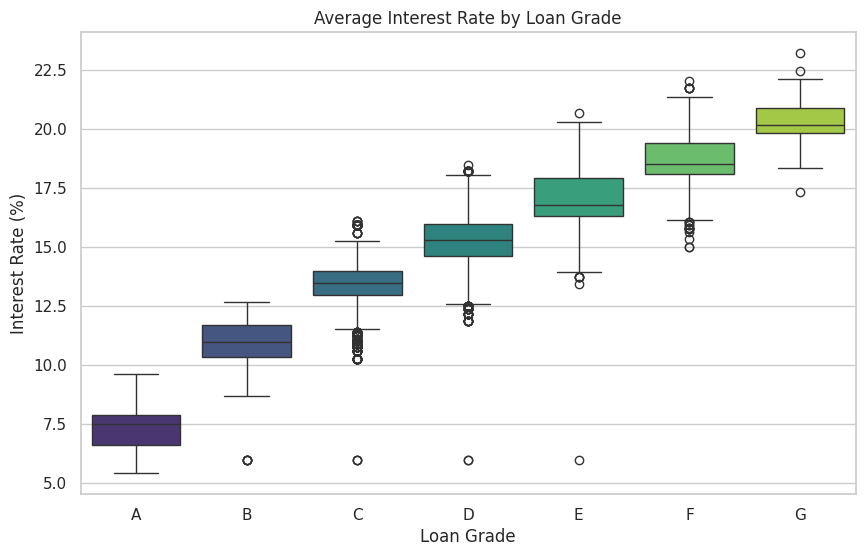

In [23]:
# @title Average Interest Rate by Loan Grade

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_for_graphic, x='loan_grade', y='loan_int_rate', palette='viridis')
plt.title('Average Interest Rate by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate (%)')
plt.show()

In [24]:
# Creating the pivot table
pivot_table2 = data_for_graphic.pivot_table(index='loan_grade', columns='loan_status', aggfunc='size', fill_value=0)

# Renaming the columns for clarity
pivot_table2.columns = ['Non-Default', 'Default']

# Adding a Total column
pivot_table2['Total'] = pivot_table2.sum(axis=1)

# Calculating the Default Ratio
pivot_table2['Default Ratio'] = pivot_table2['Default'] / pivot_table2['Total']

# Sorting the table by Default Ratio in descending order
pivot_table2 = pivot_table2.sort_values(by='Default Ratio', ascending=False)

# Convert to dataframe
pivot_table2 = pd.DataFrame(pivot_table2)

# make new column for index
pivot_table2.reset_index(inplace=True)

# Displaying the results
print(pivot_table2)
print('--------------------------------------------------------')
print(pivot_table2['Default Ratio'].describe())

  loan_grade  Non-Default  Default  Total  Default Ratio
0          G            1       58     59       0.983051
1          F           63      146    209       0.698565
2          E          308      562    870       0.645977
3          D         1325     1922   3247       0.591931
4          C         4540     1157   5697       0.203089
5          B         7696     1453   9149       0.158815
6          A         8496      904   9400       0.096170
--------------------------------------------------------
count    7.000000
mean     0.482514
std      0.333673
min      0.096170
25%      0.180952
50%      0.591931
75%      0.672271
max      0.983051
Name: Default Ratio, dtype: float64


1. Risk Assessment:
* Highest Risk: Grade G has the highest default ratio (0.983051), meaning almost all loans in this grade default.
* Moderate Risk: Grades F, E, and D show moderately high default ratios (0.698565, 0.645977, 0.591931 respectively).
* Lower Risk: Grades C, B, and A have significantly lower default ratios, with A being the safest (0.096170).


2. Statistical Review:
* The Default Ratio is highly skewed towards lower grades with higher default risks.
* Given the skewness, the median default ratio (0.591931) is a better measure of central tendency than the mean (0.482514), which is affected by extreme values.
* The variability (standard deviation of 0.333673) shows substantial variation in default ratios across different loan grades.

**Insight:**

---
* Interest rates tend to be higher for lower loan ratings. This is likely because borrowers with lower creditworthiness (reflected by lower loan ratings) are considered higher risk by lenders and are charged higher interest rates.
* High interest rates increase the risk of loan repayment failure by debtors. Consequently, as interest rates rise, borrowers are more likely to default on their loans, leading to their classification as high-risk borrowers.
* The interest rate distribution is wider for lower loan amounts, indicating greater variation in interest rates for borrowers with lower creditworthiness.
* There are several outliers for both high and low interest rates. These outliers may represent borrowers with unique conditions that affect their interest rates.

<ipython-input-132-29bc4639c8f9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_for_graphic, x='person_home_ownership', y='loan_amnt', palette='magma')


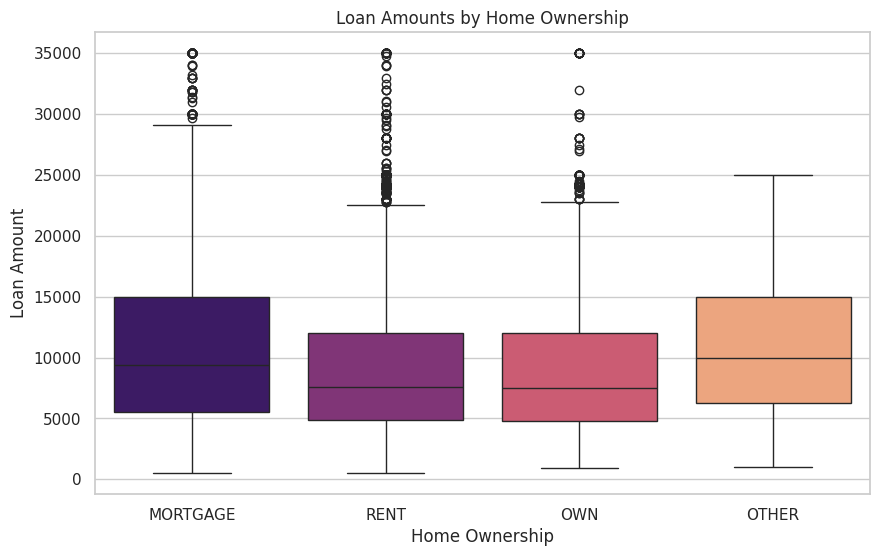

In [ ]:
# @title Loan Amounts by Home Ownership
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_for_graphic, x='person_home_ownership', y='loan_amnt', palette='magma')
plt.title('Loan Amounts by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Loan Amount')
plt.show()

**Description**

* Median Loan Amount: Borrowers categorized under "OTHER" have the highest median loan amounts, followed by those with mortgages. Renters and homeowners without a mortgage have similar median loan amounts, slightly lower than the other categories.
* Outliers: All categories exhibit a number of high-value outliers, indicating that some borrowers are receiving significantly larger loan amounts than the majority.
* IQR and Spread: The IQR is widest for the "OTHER" category, indicating greater variability in loan amounts. In contrast, the "OWN" category has a narrower IQR, suggesting more consistency in loan amounts.

In [ ]:
# Calculate credit grade based on type of home ownership

credit_grade_by_homeownership = df.groupby('person_home_ownership')['loan_grade'].agg(lambda x: x.mode()[0])
print(credit_grade_by_homeownership)

person_home_ownership
MORTGAGE    A
OTHER       B
OWN         A
RENT        B
Name: loan_grade, dtype: object


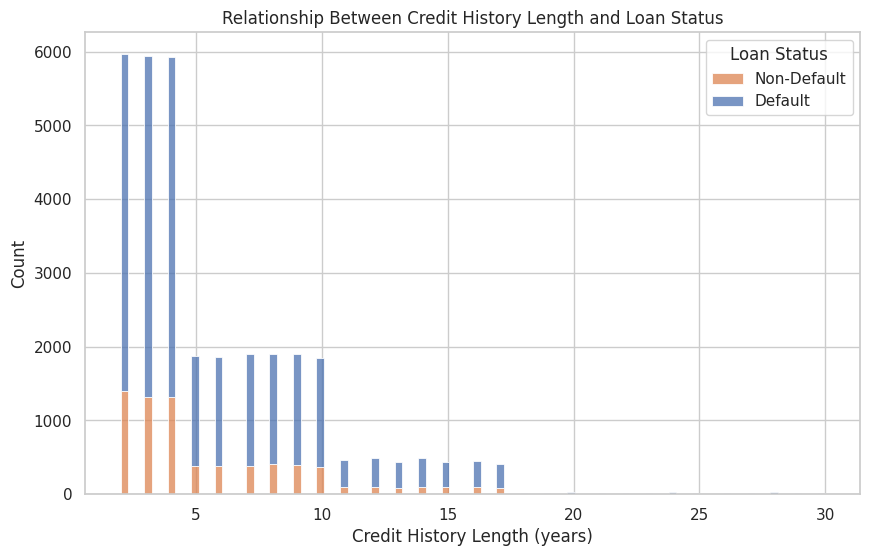

In [ ]:
# @title Relationship Between Credit History Length and Loan Status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='cb_person_cred_hist_length', hue='loan_status', multiple='stack')
plt.title('Relationship Between Credit History Length and Loan Status')
plt.xlabel('Credit History Length (years)')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right', labels=['Non-Default', 'Default'])
plt.show()

The histogram reveals a clear correlation between shorter credit histories and higher default rates. This insight, combined with previous analyses, suggests that lenders should pay close attention to borrowers with short credit histories, especially when they are also in high-risk loan categories such as Debt Consolidation and Medical loans

**Description**
* The histogram shows the distribution of credit history lengths (in years) for borrowers categorized by loan status: Non-Default and Default.
* Default Loans (blue bars) are significantly higher in count across all credit history lengths compared to Non-Default Loans (orange bars).

---
* Short Credit Histories (0-5 years): The majority of both Default and Non-Default loans are concentrated in this range. Notably, Default loans dominate in this segment.
* Moderate Credit Histories (6-10 years): There are still a substantial number of Default loans, although the counts start to decrease. Non-Default loans also decrease but remain present.
* Long Credit Histories (>10 years): Both Default and Non-Default loans drop significantly, with few loans in this range. The counts for both categories taper off, indicating fewer borrowers with long credit histories.

In [ ]:
df_clean.value_counts('loan_grade')

loan_grade
A    9400
B    9149
C    5697
D    3247
E     870
F     209
G      59
Name: count, dtype: int64

### Conclusion
---

1. Default Risks and Credit History:

* Short Credit Histories: The high concentration of Default loans among borrowers with short credit histories suggests a higher risk associated with less experienced borrowers. This aligns with the previous finding that Debt Consolidation and Medical loans, which have higher default ratios, may be prevalent among less experienced borrowers.
* Long Credit Histories: Borrowers with longer credit histories appear to be fewer in number and have a more balanced distribution of Default and Non-Default loans. This could indicate better financial management and lower default risk, aligning with the lower default ratios observed in Education and Venture loans.

2. Loan Amounts and Home Ownership:

* Borrowers with short credit histories, especially those renting or owning homes without mortgages, might be more prone to defaulting, as seen in the previous analysis of loan amounts by home ownership. This indicates that short credit history combined with certain home ownership types could be a strong indicator of default risk.

3. Risk Management Strategies:

* Short Credit Histories: Lenders should implement stricter risk assessments and possibly limit loan amounts or adjust interest rates for borrowers with shorter credit histories to mitigate default risks.
* Longer Credit Histories: Borrowers with longer credit histories might be offered better loan terms due to their demonstrated financial reliability. These borrowers could be targeted for Education and Venture loans, which have shown lower default ratios.

## Preprocessing




**One Hot encoding**

In [ ]:
df_num = df_clean.select_dtypes(exclude='object')
df_str = df_clean.select_dtypes(include='object')

df_str_onehot = pd.get_dummies(df_str).astype(int)

df_prep = pd.concat([df_num,df_str_onehot], axis = 1)

print(df_prep.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')


In [ ]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28631 entries, 1 to 32580
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      28631 non-null  int64  
 1   person_income                   28631 non-null  int64  
 2   person_emp_length               28631 non-null  float64
 3   loan_amnt                       28631 non-null  int64  
 4   loan_int_rate                   28631 non-null  float64
 5   loan_status                     28631 non-null  int64  
 6   loan_percent_income             28631 non-null  float64
 7   cb_person_cred_hist_length      28631 non-null  int64  
 8   person_home_ownership_MORTGAGE  28631 non-null  int64  
 9   person_home_ownership_OTHER     28631 non-null  int64  
 10  person_home_ownership_OWN       28631 non-null  int64  
 11  person_home_ownership_RENT      28631 non-null  int64  
 12  loan_intent_DEBTCONSOLIDATION   28631

In [ ]:
# Separate features and target
X = df_prep.drop('loan_status', axis=1)
y = df_prep['loan_status']

# Identify categorical features for SMOTENC
cf = X.apply(lambda col: col.isin([0, 1]).all())
cat_features_col = [X.columns.get_loc(str(key)) for key, value in cf.items() if value]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTENC
smotenc = SMOTENC(categorical_features=cat_features_col, k_neighbors=5, random_state=456)
X_train_balanced, y_train_balanced = smotenc.fit_resample(X_train, y_train)


In [ ]:
X_train_balanced.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,23,35000,7.0,5400,10.59,0.15,2,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,28,150000,6.0,10000,8.07,0.07,8,1,0,0,...,1,1,0,0,0,0,0,0,1,0
2,25,110000,1.0,10000,12.69,0.09,3,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,26,51000,10.0,5000,12.42,0.10,4,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,25,50000,9.0,8000,10.00,0.16,2,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
# Feature scaling after SMOTENC
scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Reshape data
X_train_balanced_scaled = X_train_balanced_scaled.reshape(X_train_balanced_scaled.shape[0], 1, X_train_balanced_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

## Model Building


### Bidirectional LSTM

In [ ]:
# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, X_train_balanced_scaled.shape[2])))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 1, 128)            46592     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 87873 (343.25 KB)
Trainable params: 8787

In [ ]:
# Train the model
history = model.fit(X_train_balanced_scaled, y_train_balanced, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/20
895/895 [==============================] - 19s 12ms/step - loss: 0.3094 - accuracy: 0.8830 - val_loss: 0.0811 - val_accuracy: 0.9654
Epoch 2/20
895/895 [==============================] - 7s 8ms/step - loss: 0.2415 - accuracy: 0.9123 - val_loss: 0.0692 - val_accuracy: 0.9689
Epoch 3/20
895/895 [==============================] - 9s 10ms/step - loss: 0.2290 - accuracy: 0.9170 - val_loss: 0.0650 - val_accuracy: 0.9708
Epoch 4/20
895/895 [==============================] - 7s 8ms/step - loss: 0.2248 - accuracy: 0.9191 - val_loss: 0.0614 - val_accuracy: 0.9721
Epoch 5/20
895/895 [==============================] - 9s 10ms/step - loss: 0.2191 - accuracy: 0.9209 - val_loss: 0.0560 - val_accuracy: 0.9742
Epoch 6/20
895/895 [==============================] - 8s 9ms/step - loss: 0.2149 - accuracy: 0.9218 - val_loss: 0.0582 - val_accuracy: 0.9705
Epoch 7/20
895/895 [==============================] - 7s 8ms/step - loss: 0.2135 - accuracy: 0.9229 - val_loss: 0.0575 - val_accuracy: 0.9722
Ep

In [ ]:
# Predict probabilities
preds = model.predict(X_test_scaled)
preds_df = pd.DataFrame(preds, columns=['prob_default'])
true_df = pd.DataFrame(y_test.reset_index(drop=True), columns=['loan_status'])

# Concatenate and print the data frames for comparison
results_df = pd.concat([true_df, preds_df], axis=1)
print(results_df.head())


179/179 [==============================] - 2s 3ms/step
   loan_status  prob_default
0            1      0.898414
1            0      0.520750
2            1      0.120357
3            0      0.077054
4            0      0.000756


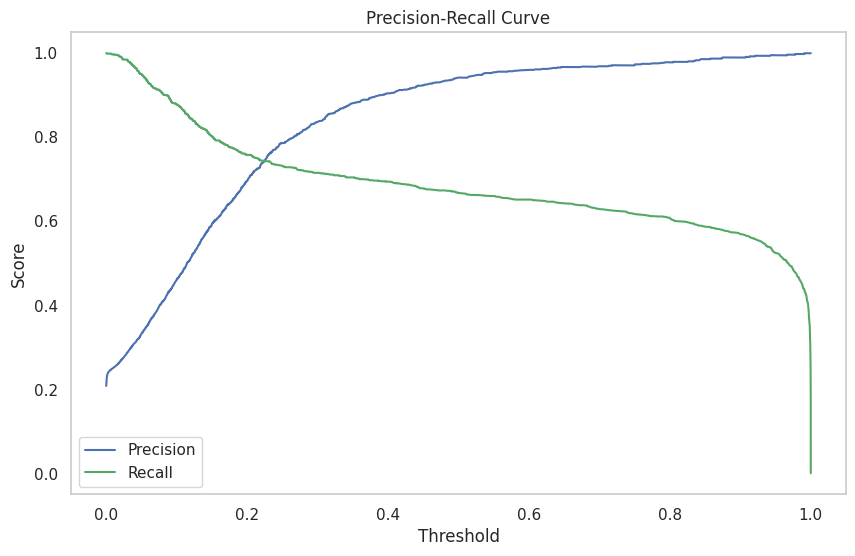

In [ ]:
# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(true_df['loan_status'], preds_df['prob_default'])

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Find the threshold that maximizes recall while maintaining a minimum desired recall

desired_recall = 0.85  # Adjust this value based on acceptable recall
optimal_threshold = thresholds[np.argmax(precision * (recall >= desired_recall))]
print(f'Optimal Threshold: {optimal_threshold:.5f}')

Optimal Threshold: 0.11762


In [ ]:
# Apply the optimal threshold to get predictions
results_df['predicted_default'] = (results_df['prob_default'] >= optimal_threshold).astype(int)

# Generate the classification report with the optimal threshold
final_report = classification_report(results_df['loan_status'], results_df['predicted_default'])
print(final_report)

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      4532
           1       0.51      0.85      0.63      1195

    accuracy                           0.80      5727
   macro avg       0.73      0.82      0.75      5727
weighted avg       0.86      0.80      0.81      5727

